
# Meta Migration In — Hands‑On Tutorial (Jupyter Notebook)

This notebook is a beginner‑friendly guide for working with the **Mapineq API** using the dataset **`meta_migration_in`**.  
No server setup is needed — everything runs from your computer in this notebook.

**You will:**
- Discover which **years** and **NUTS levels** are available.
- See which **origin** values (countries) you can filter by.
- Download data for a **chosen origin**.
- Compute **totals across all origins** per destination.
- Save results to **CSV files** and make a simple **bar chart**.

> **Requirements:** `requests`, `pandas`, `matplotlib`


## 1) Setup

In [ ]:
# If you're running this on a fresh environment, uncomment the next line:
# !pip install requests pandas matplotlib

## 2) Imports and constants

In [9]:
import json
import os
from typing import List, Dict, Any

import requests
import pandas as pd
import matplotlib.pyplot as plt

# API base and dataset
BASE = "https://api.mapineq.org"
# RESOURCE = "meta_migration_in"
RESOURCE = "meta_sci"

# Default choices for an easy demo (change them later in Section 6)
ORIGIN_CHOICE = "UA"   # e.g., 'UA' for Ukraine; you'll see available options below
YEAR_CHOICE   = None   # None = auto pick latest available
LEVEL_CHOICE  = 0      # 0 (country level); can be 1/2/3 if available in coverage

SAVE_DIR = "outputs_meta_migration_in"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Setup complete.")


Setup complete.


## 3) Helper functions

In [10]:

def _get(url: str, params: Dict[str, Any]) -> Any:
    """Wrapper around requests.get with basic error handling."""
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

def coverage(resource: str) -> pd.DataFrame:
    """Return valid (year, level) pairs for a resource."""
    data = _get(
        f"{BASE}/functions/postgisftw.get_year_nuts_level_from_source/items.json",
        {"_resource": resource}
    )
    df = pd.DataFrame(data).rename(columns={"f_level": "level", "f_year": "year"})
    if df.empty:
        raise RuntimeError("No coverage returned for this resource.")
    df["year"] = df["year"].astype(int)
    df["level"] = df["level"].astype(int)
    return df.sort_values(["level", "year"]).reset_index(drop=True)

def list_filters(resource: str, year: int, level: int) -> pd.DataFrame:
    """Return a tidy table of filter options (field, field_label, label, value)."""
    sel = {"year": str(year), "level": str(level), "selected": []}
    data = _get(
        f"{BASE}/functions/postgisftw.get_column_values_source_json/items.json",
        {"_resource": resource, "source_selections": json.dumps(sel)}
    )
    rows = []
    for item in (data or []):
        field = item.get("field")
        field_label = item.get("field_label")
        values = item.get("field_values") or []
        if not values:
            rows.append({"field": field, "field_label": field_label, "label": None, "value": None})
        else:
            for v in values:
                rows.append({
                    "field": field,
                    "field_label": field_label,
                    "label": v.get("label"),
                    "value": v.get("value"),
                })
    return pd.DataFrame(rows, columns=["field", "field_label", "label", "value"])

def get_x_data(resource: str, year: int, level: int, conditions: List[Dict[str, str]], limit: int = 50000) -> pd.DataFrame:
    """Fetch observations for a resource given filters (conditions)."""
    payload = {"source": resource, "conditions": conditions}
    data = _get(
        f"{BASE}/functions/postgisftw.get_x_data/items.json",
        {"_level": level, "_year": year, "X_JSON": json.dumps(payload), "limit": limit}
    )
    df = pd.DataFrame(data)
    if "x" in df.columns:
        df["x"] = pd.to_numeric(df["x"], errors="coerce")
    return df


## 4) Explore coverage (years × NUTS levels)

In [11]:
cov = coverage(RESOURCE)
display(cov)
print(f"Available years: {sorted(cov['year'].unique().tolist())}")
print(f"Available levels: {sorted(cov['level'].unique().tolist())}")

,level,year
0,0,2021
1,2,2021
2,3,2021


Available years: [2021]
Available levels: [0, 2, 3]


## 5) Choose a year and NUTS level

In [12]:
# Pick year (latest if YEAR_CHOICE is None) and a valid level
year = int(cov["year"].max()) if YEAR_CHOICE is None else int(YEAR_CHOICE)

# If LEVEL_CHOICE isn't available for that year, fall back to the first level for the year (or first row overall)
candidates = cov[(cov["year"] == year)]
if candidates.empty:
    print("[info] No rows for the chosen year; using the first row in coverage.")
    row = cov.iloc[0]
else:
    row = candidates.iloc[0]

level = int(LEVEL_CHOICE) if LEVEL_CHOICE is not None else int(row["level"])
if cov[(cov["year"] == year) & (cov["level"] == level)].empty:
    print(f"[info] Level {level} not available for year {year}; using level {int(row['level'])}.")
    level = int(row["level"])

print(f"Using year={year}, level={level}")


Using year=2021, level=0


## 6) See available filters (e.g., `origin`)

In [13]:
filters_df = list_filters(RESOURCE, year, level)
display(filters_df.head(20))

origin_values = filters_df.loc[filters_df["field"] == "origin", "value"].dropna().unique().tolist()
print(f"Found {len(origin_values)} origin options. Example: {origin_values[:25]}")

# Pick an origin value to use (fall back to first if the default isn't present)
if origin_values:
    origin = ORIGIN_CHOICE if ORIGIN_CHOICE in origin_values else origin_values[0]
    if origin != ORIGIN_CHOICE:
        print(f"[info] ORIGIN_CHOICE '{ORIGIN_CHOICE}' not found; using '{origin}'.")
else:
    origin = None
    print("[info] No origin filters exposed for this resource/year/level.")

,field,field_label,label,value
0,friend_country,friend_country,DK,DK
1,friend_country,friend_country,SV,SV
2,friend_country,friend_country,SN,SN
3,friend_country,friend_country,SI,SI
4,friend_country,friend_country,CZ,CZ
5,friend_country,friend_country,KR,KR
6,friend_country,friend_country,JP,JP
7,friend_country,friend_country,BS,BS
8,friend_country,friend_country,UZ,UZ
9,friend_country,friend_country,TL,TL


Found 0 origin options. Example: []
[info] No origin filters exposed for this resource/year/level.


## 7) Download data for one origin

In [14]:
if origin is None:
    # No filters: fetch without conditions
    df_one = get_x_data(RESOURCE, year, level, conditions=[])
    df_one = df_one.rename(columns={"x": "migration_in"})
else:
    df_one = get_x_data(RESOURCE, year, level, conditions=[{"field": "origin", "value": origin}])
    df_one = df_one.rename(columns={"x": f"migration_in_from_{origin}"})

display(df_one.head())
print(df_one.shape)

,data_year,geo,geo_name,geo_source,geo_year,migration_in
0,2021,AL,Shqip�ria,NUTS,2024,2101.0
1,2021,AL,Shqip�ria,NUTS,2024,641.0
2,2021,AL,Shqip�ria,NUTS,2024,14884656.0
3,2021,AL,Shqip�ria,NUTS,2024,896.0
4,2021,AL,Shqip�ria,NUTS,2024,689.0


(6292, 6)


## 8) Compute totals per destination (sum across origins)

In [15]:
if origin_values:
    # Try to use a built-in TOTAL if present, else sum manually
    total_candidates = [o for o in origin_values if str(o).upper() in ("TOTAL", "TOT", "ALL")]
    if total_candidates:
        df_total = get_x_data(RESOURCE, year, level, conditions=[{"field": "origin", "value": total_candidates[0]}])
        df_total = df_total.rename(columns={"x": "migration_in_total"})
    else:
        frames = []
        for ov in origin_values:
            d = get_x_data(RESOURCE, year, level, [{"field": "origin", "value": ov}])
            d = d[["data_year", "geo", "geo_name", "geo_source", "geo_year", "x"]]
            frames.append(d)
        big = pd.concat(frames, ignore_index=True)
        df_total = (big.groupby(["data_year", "geo", "geo_name", "geo_source", "geo_year"], as_index=False)["x"]
                       .sum()
                       .rename(columns={"x": "migration_in_total"}))
else:
    # No origin filters → single call already represents totals
    df_total = df_one.rename(columns={df_one.columns[-1]: "migration_in_total"})

display(df_total.head())
print(df_total.shape)

,data_year,geo,geo_name,geo_source,geo_year,migration_in_total
0,2021,AL,Shqip�ria,NUTS,2024,2101.0
1,2021,AL,Shqip�ria,NUTS,2024,641.0
2,2021,AL,Shqip�ria,NUTS,2024,14884656.0
3,2021,AL,Shqip�ria,NUTS,2024,896.0
4,2021,AL,Shqip�ria,NUTS,2024,689.0


(6292, 6)


## 9) Save tidy CSV files

In [16]:
p_one = os.path.join(SAVE_DIR, f"meta_migration_in_{year}_L{level}_one_origin.csv")
p_tot = os.path.join(SAVE_DIR, f"meta_migration_in_{year}_L{level}_totals.csv")

df_one.to_csv(p_one, index=False)
df_total.to_csv(p_tot, index=False)

print("Saved:")
print("-", p_one)
print("-", p_tot)

Saved:
- outputs_meta_migration_in/meta_migration_in_2021_L0_one_origin.csv
- outputs_meta_migration_in/meta_migration_in_2021_L0_totals.csv


## 10) Plot top destinations by total inflow

Chart saved: outputs_meta_migration_in/meta_migration_in_2021_L0_totals_top15.png


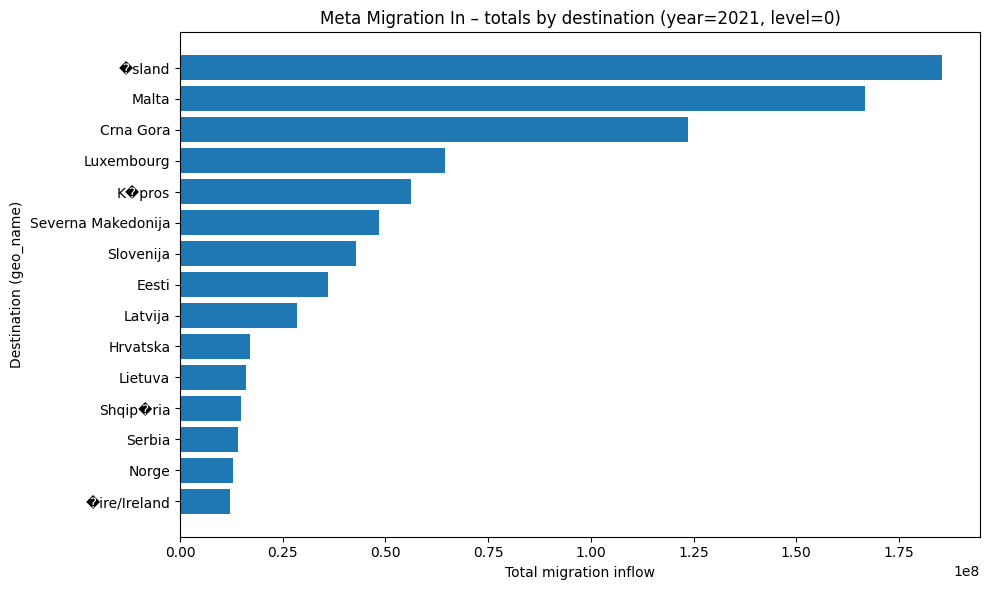

In [17]:
topN = 15
top = df_total.sort_values("migration_in_total", ascending=False).head(topN)

plt.figure(figsize=(10, 6))
plt.barh(top["geo_name"], top["migration_in_total"])
plt.gca().invert_yaxis()
plt.xlabel("Total migration inflow")
plt.ylabel("Destination (geo_name)")
plt.title(f"Meta Migration In – totals by destination (year={year}, level={level})")
plt.tight_layout()

chart_path = os.path.join(SAVE_DIR, f"meta_migration_in_{year}_L{level}_totals_top{topN}.png")
plt.savefig(chart_path, dpi=150)
print("Chart saved:", chart_path)


## 11) What you can explain to a non‑technical audience

- We asked the **Mapineq API** which **years** and **regional levels** are available for *meta_migration_in*.
- We saw the available **origin** values (source countries).
- We downloaded data for one origin and also **summed across all origins** to get totals per destination.
- We saved two **CSV files** and a **PNG chart** to the `outputs_meta_migration_in` folder.
- You can now change `ORIGIN_CHOICE`, `YEAR_CHOICE`, and `LEVEL_CHOICE` at the top and re‑run to answer “what‑if” questions.
